In [383]:
# This will be very descriptive about how the makemore2 works. We will get more into pytorch within this
# for this notebook, I am not going to add in the train and test set splitting. I will do so in the future notebooks

In [118]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [119]:
# read all words
words= open('names.txt', 'r').read().splitlines()

In [120]:
len(words)

32033

In [121]:
# build the vocabulary of characters and mapping to/from integers
chars= sorted(list(set(''.join(words))))
stoi= {s:i+1 for i,s in enumerate(chars)}
# build special characters for the start and end
stoi['.'] = 0
itos= {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [122]:
# to build a dataset

# consider that we only want a block size or starting context to predict each letter
blockSize= 3
X, Y = [], []
for w in words[:5]:
    print(w)
    # initialize the context to be of size blockSize and nothing inside
    context= [0] * blockSize
    # for each character, we want to construct the context used to find answer or predicted character
    # we are trying to build something like this
    # ['.', '.', '.'] is used to predict ['a']
    # and so forth
    for ch in w + '.':
        ix = stoi[ch]
        # we add into the context data set used for prediction (in numbers)
        X.append(context)
        # and then we also add the related answer in integer format
        Y.append(ix)
        print(''.join(itos[i] for i in context), '-->', itos[ix])
        # then we need to consider updating the context to prepare what the context is ued for next prediction
        context = context[1:] + [ix]

X= torch.tensor(X)
Y= torch.tensor(Y)

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [123]:
# now we need to get into the context (X) and how to predict the Y
# we need to start out with some embedding lookup table

# he were are going to condense the 27 letters into 2 dimensional space
C = torch.rand((27,2))

# this means: we have 2 attributes/values that is used to encode a letter/integer for the letter

In [124]:
# from the first 5 words, we will have X.shape examples to go from alongside Y.shape outputs/answers
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [125]:
# we can index into the embedding table normally like
C[5]
# or through a tensor
C[torch.tensor(5)]
# or even through a larger tensor, we can use the example for how the examples
# are shown through the embeddings
# basically, using the embeddings tables, showcase the context with the embedded values for each character
C[X]

tensor([[[0.8987, 0.0592],
         [0.8987, 0.0592],
         [0.8987, 0.0592]],

        [[0.8987, 0.0592],
         [0.8987, 0.0592],
         [0.9669, 0.3707]],

        [[0.8987, 0.0592],
         [0.9669, 0.3707],
         [0.1094, 0.9712]],

        [[0.9669, 0.3707],
         [0.1094, 0.9712],
         [0.1094, 0.9712]],

        [[0.1094, 0.9712],
         [0.1094, 0.9712],
         [0.8704, 0.5595]],

        [[0.8987, 0.0592],
         [0.8987, 0.0592],
         [0.8987, 0.0592]],

        [[0.8987, 0.0592],
         [0.8987, 0.0592],
         [0.2211, 0.2046]],

        [[0.8987, 0.0592],
         [0.2211, 0.2046],
         [0.2085, 0.8658]],

        [[0.2211, 0.2046],
         [0.2085, 0.8658],
         [0.4294, 0.8042]],

        [[0.2085, 0.8658],
         [0.4294, 0.8042],
         [0.5238, 0.3325]],

        [[0.4294, 0.8042],
         [0.5238, 0.3325],
         [0.4294, 0.8042]],

        [[0.5238, 0.3325],
         [0.4294, 0.8042],
         [0.8704, 0.5595]],

    

In [126]:
C[X].shape

torch.Size([32, 3, 2])

In [127]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [48]:
# we can choose the 'second' layer or number of neurons - in this case we chose 100
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [51]:
# We would need to do the embedding .matmul or @ with the weights
# PROBLEM: we can't do that right now since emb is of shape 32x3x2 and W1 is 6x100
# matrix multiplication won't work with this it needs to be 32x6 @ 6x100

# what we can do is turn the emb into 32x6

# METHOD 1:
# concatenate each of the second (1) dimension (which contains the embeddings) and retaining the first dimension (0)
torch.cat([emb[:,0, :], emb[:, 0, :], emb[:, 0, :]], 1).shape

# METHOD 2:
# do with torch.unbind - I am imagining this as unfurling everything against a certain dimension and breaking barriers
torch.cat(torch.unbind(emb, 1), 1).shape

# METHOD 3: easily done with view. also -1 is to assume the actual first dimension (0)
# which is the same as emb.view(32, 6).shape
# emb.view(emb.shape[0], 6).shape
emb.view(-1,6).shape

torch.Size([32, 6])

In [52]:
h = emb.view(-1,6) @ W1 + b1

# now that we can matrix multiply them, we can now get into the actual from input to second layer (100)
h.shape

torch.Size([32, 100])

In [58]:
# but we aren't done, we need to make this an activation layer with tanh
# tanh is an activation method - to detemine how much inputs are activating neurons to help determine an output
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[-0.3712, -0.9268, -0.5447,  ..., -0.1120,  0.0221, -0.7995],
        [-0.6500, -0.9487, -0.3599,  ...,  0.0135,  0.0153, -0.6403],
        [-0.8691, -0.9523,  0.3634,  ...,  0.2273,  0.0426, -0.1092],
        ...,
        [-0.9811, -0.9593,  0.4293,  ...,  0.3320,  0.3126,  0.1718],
        [-0.9443, -0.9898, -0.9082,  ...,  0.0523, -0.4966,  0.2368],
        [ 0.1598, -0.9980, -0.5527,  ..., -0.7439,  0.4646, -0.9241]])

In [59]:
# now there is something that is happening here that needs to be considered, check out Broadcasting

In [60]:
# now we can consider the final output layer, basically the predictions that we want to come out with
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [61]:
# logits are the raw scores that come out - we will need to normalize them later
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [62]:
# now we have to noralize these outputs
counts = logits.exp()

In [68]:
# now we can provide the probabilities after normalizing the results
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [71]:
# we will now need to calculate the loss but first we want to check out the probably in relation to our outputs
prob[torch.arange(32), Y]

tensor([3.8326e-08, 3.8800e-01, 3.1822e-01, 2.6593e-12, 1.3562e-07, 1.6771e-14,
        2.4845e-06, 3.8503e-11, 1.1537e-04, 1.8708e-10, 1.0023e-15, 6.5709e-08,
        2.8670e-15, 7.3632e-07, 1.8952e-15, 5.9944e-09, 1.0149e-09, 4.7629e-07,
        4.0095e-17, 3.5814e-08, 3.5856e-06, 4.9048e-06, 5.4525e-06, 1.6544e-15,
        2.5030e-07, 3.2234e-08, 6.5850e-14, 1.4592e-14, 1.2569e-09, 3.4408e-09,
        3.1143e-14, 3.0366e-07])

In [74]:
# now we can the log probability and then the average of them to find the negative log likelihood loss
# LOSS
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(20.4705)

In [88]:
#### THIS SECTION IS REORGANIZING EVERYTHING TO MAKE IT LOOK NICER AND EASIER TO FOLLOW #####
X.shape, Y.shape ## dataset

(torch.Size([32, 3]), torch.Size([32]))

In [128]:
g = torch.Generator().manual_seed(2147483647) # this is for reproducability
# Embedding matrix mapping each of the 27 possible characters to a 2D vector representation
C = torch.randn((27,2), generator=g)
# Weights and biases for the first linear layer: input of 6 (from 3 chars × 2 embedding dim) → 100 hidden units
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

# Weights and biases for output layer: 100 → 27 (each output logit corresponds to one possible next character).
W2= torch.randn((100, 27), generator=g)
b2= torch.randn(27, generator=g)

# just to organize it all together
parameters = [C, W1, b1, W2, b2]

In [129]:
# we can also see how many parameters there are
sum(p.nelement() for p in parameters)

3481

In [130]:
# Look up embeddings for each of the 3 input characters in every one of the 32 examples. Shape becomes (32, 3, 2)
emb= C[X]

# Flatten the 3×2 embeddings (per example) into a 1D vector of 6 pieces with view,
# then apply the first linear layer and tanh activation to produce 100 hidden activations per example
# h is representation of the hidden activations for the 32 examples
h= torch.tanh(emb.view(-1, 6) @ W1 + b1)

# get the raw scores on output, so another layer of calculations
# Transform 100 hidden activations into 27 logits — one unnormalized score per possible output character.
logits= h @ W2 + b2

############## THIS SECTION BELOW WITH COUNTS, PROB, AND LOSS CAN BE DONE THROUGH Functional.cross_entropy(logits, Y) finding the same loss ######
# below is just for educational purposes but at scale and everything else, this isn't efficient or fully implemented for everything

# This is an example of the transition of before and after the logits.exp()
# logits[i] = [-2.0, 0.0, 1.0]
# counts[i] = [e^(-2.0), e^(0.0), e^(1.0)] ≈ [0.135, 1.0, 2.718]

# Compute probabilities for each class using a simple (non-stable)
# softmax: exponentiate logits, then normalize across 27 possible next characters
counts = logits.exp()

# counts[i] = [0.135, 1.0, 2.718]
# sum[i] = 0.135 + 1.0 + 2.718 = 3.853
# probs[i] = [0.035, 0.259, 0.706]

prob = counts / counts.sum(1, keepdims=True)

# get the negative log likelihood and loss
# Compute the negative log-likelihood (cross-entropy) loss:
# For each example i in the batch (0–31), take the probability that the model
# assigned to the correct next character Y[i], i.e. probs[i, Y[i]].
# The log makes confident predictions less penalized (log(1) = 0),
# the negative sign turns low probabilities into larger penalties,
# and .mean() averages the 32 losses into one scalar.
#
# Essentially: For each example (row) in the batch, look up the probability the
# model assigned to the true next character (Y[i]), take its log,
# negate it (so higher probs → smaller loss), then average over the batch.
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [103]:
p_true = probs[torch.arange(32), Y]
log_p_true = p_true.log()
neg_log_p_true = -log_p_true

pd.set_option("display.precision", 4)

df = pd.DataFrame({
    "example_idx": torch.arange(32).tolist(),
    "Y_true_index": Y.tolist(),
    "p_true": p_true.detach().tolist(),
    "-log(p_true)": neg_log_p_true.detach().tolist()
})
display(df.head(10))
print(f"\nAverage loss across batch = {loss.item():.4f}")

,example_idx,Y_true_index,p_true,-log(p_true)
0,0,5,1.5213e-14,31.8166
1,1,13,1.2830e-12,27.3818
2,2,13,1.9647e-08,17.7454
3,3,1,3.1758e-10,21.8703
4,4,0,5.6763e-12,25.8947
5,5,15,1.0823e-10,22.9467
6,6,12,1.8821e-14,31.6038
7,7,9,1.1087e-08,18.3175
8,8,22,1.6134e-09,20.2449
9,9,9,2.1917e-03,6.1231



Average loss across batch = 17.7697


In [131]:
##### In practice, cross_entropy would be used instead - there are many more beefits that are found with cross_entropy instead
loss  = F.cross_entropy(logits, Y)
# this loss should present the same loss as the calculated loss above
loss

tensor(17.7697)

In [111]:
# Everything up til this point has been for the forward pass
# This point on is the backward pass

In [132]:
# need to ensure that all parameterse has grad set to true
for p in parameters:
    p.requires_grad = True

In [ ]:
## THIS IS REALLY BASIC - and this is just an idea / PARTIAL IMPLEMENTATION.
## actual implementation will come later
for p in parameters:
    p.grad = None
loss.backward()
# update
for p in parameters:
    p.data += -0.1 * p.grad

In [191]:
# RESET DATA SET

# consider that we only want a block size or starting context to predict each letter
blockSize= 3
X, Y = [], []
for w in words:
    # initialize the context to be of size blockSize and nothing inside
    context= [0] * blockSize
    # for each character, we want to construct the context used to find answer or predicted character
    # we are trying to build something like this
    # ['.', '.', '.'] is used to predict ['a']
    # and so forth
    for ch in w + '.':
        ix = stoi[ch]
        # we add into the context data set used for prediction (in numbers)
        X.append(context)
        # and then we also add the related answer in integer format
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '-->', itos[ix])
        # then we need to consider updating the context to prepare what the context is ued for next prediction
        context = context[1:] + [ix]

X= torch.tensor(X)
Y= torch.tensor(Y)

In [192]:
# FULL REVIEW AND FULL IMPLEMENTATION AGAIN
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [193]:
g = torch.Generator().manual_seed(2147483647) # this is for reproducability
# Embedding matrix mapping each of the 27 possible characters to a 2D vector representation
C = torch.randn((27,2), generator=g)
# Weights and biases for the first linear layer: input of 6 (from 3 chars × 2 embedding dim) → 100 hidden units
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

# Weights and biases for output layer: 100 → 27 (each output logit corresponds to one possible next character).
W2= torch.randn((100, 27), generator=g)
b2= torch.randn(27, generator=g)

# just to organize it all together
parameters = [C, W1, b1, W2, b2]

In [194]:
sum(p.nelement() for p in parameters)

3481

In [195]:
for p in parameters: p.requires_grad=True

In [ ]:
for _ in range(1000):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
    logits = h @ W2 + b2
    # then we normalize and get loss
    loss = F.cross_entropy(logits, Y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

In [ ]:
logits.max(1)

In [160]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [209]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [361]:
# to build a dataset

# consider that we only want a block size or starting context to predict each letter
blockSize= 5
X, Y = [], []
for w in words:
    # print(w)
    # initialize the context to be of size blockSize and nothing inside
    context= [0] * blockSize
    # for each character, we want to construct the context used to find answer or predicted character
    # we are trying to build something like this
    # ['.', '.', '.'] is used to predict ['a']
    # and so forth
    for ch in w + '.':
        ix = stoi[ch]
        # we add into the context data set used for prediction (in numbers)
        X.append(context)
        # and then we also add the related answer in integer format
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '-->', itos[ix])
        # then we need to consider updating the context to prepare what the context is ued for next prediction
        context = context[1:] + [ix]

X= torch.tensor(X)
Y= torch.tensor(Y)

In [362]:
### okay gonna try to move everything to cuda instead since it seems to be killing up my CPU
# move inputs to device ( cuda )
X = X.to(device)
Y = Y.to(device)

In [369]:
# 2) reproducible RNG + init directly on device
g = torch.Generator(device=device).manual_seed(2147483647)

# dims
vocab_size = 27
embed_dim   = 15
hidden_dim  = 100

In [370]:
# Parameters on device (and with grads)
C  = torch.randn((vocab_size, embed_dim), generator=g, device=device, requires_grad=True)       # embedding table
W1 = torch.randn((blockSize*embed_dim, hidden_dim), generator=g, device=device, requires_grad=True)     # 6x100 if context=3, embed_dim=2
b1 = torch.randn((hidden_dim,), generator=g, device=device, requires_grad=True)
W2 = torch.randn((hidden_dim, vocab_size), generator=g, device=device, requires_grad=True)
b2 = torch.randn((vocab_size,), generator=g, device=device, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [380]:
steps = 85000

# STEP 3 let's als include a learning rate exponent (decay)
lre = torch.linspace(-3, -0, steps)
lrs = 10**lre

lri = []
lossi = []
stepi = []
minloss = 100

for i in range(steps):
    # STEP2 COME BACK LATER
    ix = torch.randint(0, X.shape[0], (32,)) # S2
    
    # forward
    # emb = C[X]                          # (batch, context, embed_dim) on GPU
    emb = C[X[ix]] # S2 now we are getting a smaller batch from the whole
    B, T, E = emb.shape                 # e.g., (32, 3, 2)
    h = torch.tanh(emb.view(-1, T*E) @ W1 + b1)  # (32, hidden_dim)
    logits = h @ W2 + b2                        # (32, vocab_size)

    # cross-entropy expects raw logits and target indices
    # loss = F.cross_entropy(logits, Y)
    loss = F.cross_entropy(logits, Y[ix]) # S2

    # backward
    for p in parameters:
        if p.grad is not None:
            p.grad.zero_()
    loss.backward()

    # update (use no_grad, avoid .data)
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    # lri.append((lre[i]))
    stepi.append(i)
    lossi.append(loss.item())
    minloss = min(minloss, loss)

print('Final loss:', loss.item())
print(minloss)

Final loss: 2.5493927001953125
tensor(1.2581, device='cuda:0', grad_fn=<NllLossBackward0>)


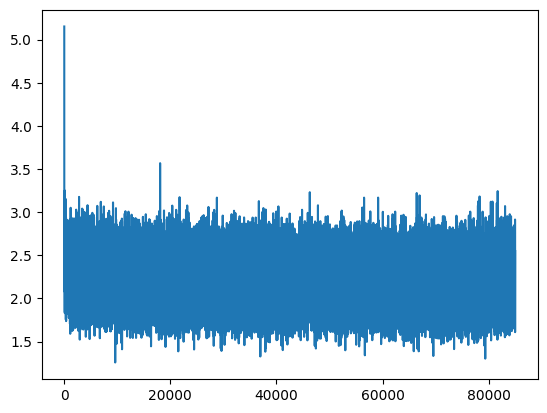

In [381]:
plt.plot(stepi, lossi)

In [378]:
# This seems to be taking too long, we can instead move onto the usage within miniBatches (random)
torch.randint(0, X.shape[0], (32,))

# with this I will add a STEP2 to the above code

tensor([161132, 137763, 156815, 221449, 101514, 224675,  58657, 226139,  13088,
        225364, 154831,  31222, 174983, 134401, 131670,  41684,  64865, 116922,
         90102, 187389,  61106,  67555,  61360, 180903, 161685, 176190, 128910,
         72755,  47026, 133884, 136604, 140088])

In [382]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * blockSize # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      prob = F.softmax(logits, dim=1)
      ix = torch.multinomial(prob, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

gurinah.
zubilia.
syze.
nelie.
taia.
mayam.
kamots.
keemon.
dalxa.
mitel.
zurav.
hodee.
browiy.
deace.
madie.
caerleiga.
dayey.
eilva.
saysiel.
sanarrus.


In [326]:
# i didn't get into building train set and the loss diagrams, that is that is mising from here